In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold,RepeatedKFold
import warnings
from six.moves import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn')
from scipy.stats import norm, skew

In [2]:
df=pd.read_csv("train.csv")
df1=pd.read_csv("test.csv")

In [12]:
df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [18]:
from sklearn.ensemble import RandomForestClassifier

# Create a copy to work with
X = df.copy()

# Save and drop labels
y = df.target
X = X.drop(["target"], axis = 1)

# fill NANs 
X = X.fillna(-999)

# Label encoder
for c in df.columns[df.dtypes == 'object']:
    X[c] = X[c].factorize()[0]
    
rf = RandomForestClassifier()
rf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

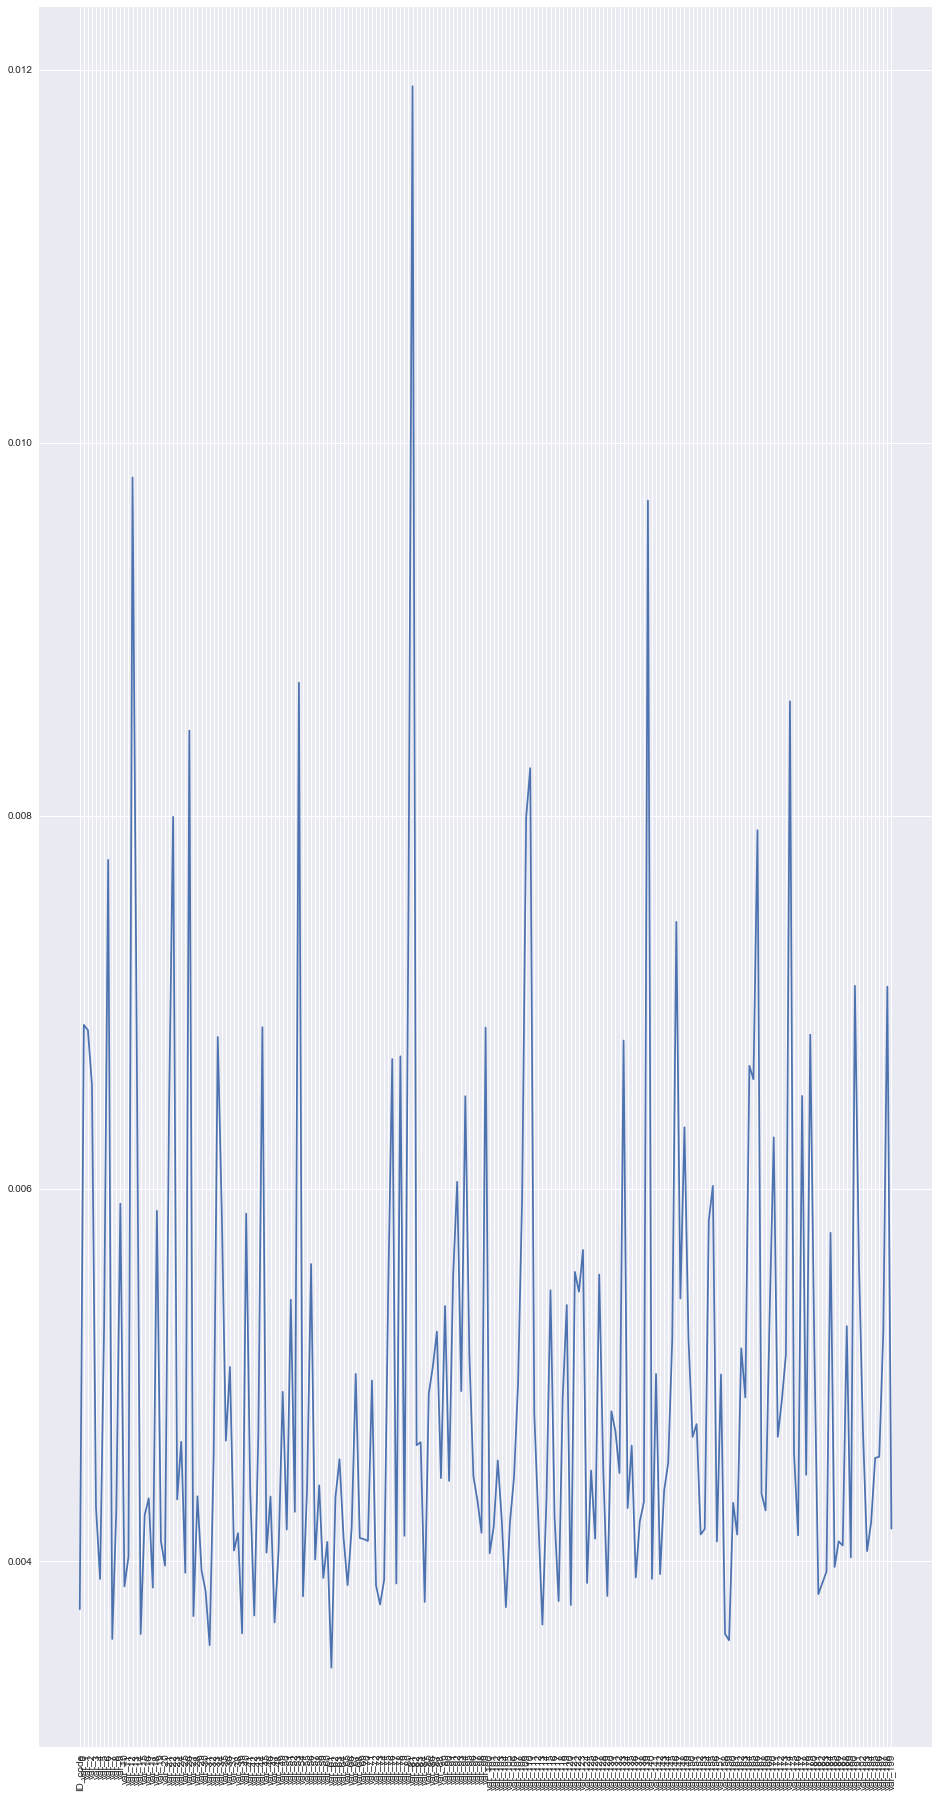

In [21]:
plt.figure(figsize=(16,32))
plt.plot(rf.feature_importances_)
plt.xticks(np.arange(X.shape[1]), X.columns.tolist(), rotation=90);

In [22]:
df.var_68.mean()

5.0188934560000416

In [20]:
param = {
        'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.041,
    'learning_rate': 0.0083,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1
#     'scale_pos_weight': 90
#     'is_unbalance': 'true'
    }



In [ ]:
nfold = 11
target = 'target'
predictors = df.columns.values.tolist()[2:]   


In [ ]:
skf = StratifiedKFold(n_splits=nfold, shuffle=False, random_state=2719)

oof = np.zeros(len(df))
predictions = np.zeros(len(df1))

i = 1
for train_index, valid_index in skf.split(df, df.target.values):
    print("\nfold {}".format(i))
    xg_train = lgb.Dataset(df.iloc[train_index][predictors].values,
                           label=df.iloc[train_index][target].values,
                           feature_name=predictors)
                        
                           
    xg_valid = lgb.Dataset(df.iloc[valid_index][predictors].values,
                           label=df.iloc[valid_index][target].values,
                           feature_name=predictors)
                           
                             

    nround = 1000000
    clf = lgb.train(param, xg_train, nround, valid_sets = [xg_valid], verbose_eval=5000,early_stopping_rounds = 4000)
    oof[valid_index] = clf.predict(df.iloc[valid_index][predictors].values, num_iteration=nround) 
    
    predictions += clf.predict(df1[predictors], num_iteration=nround) / nfold
    i = i + 1

print("\n\nCV AUC: {:<0.4f}".format(metrics.roc_auc_score(df.target.values, oof)))

In [ ]:
sub_df = pd.DataFrame({"ID_code": df1.ID_code.values})
sub_df["target"] = predictions
sub_df[:100]
sub_df.to_csv("Final.csv", index=False)

In [ ]:

print("\n\nCV AUC: {:<0.4f}".format(roc_auc_score(df.target.values, oof)))

In [ ]:
ensemble.fit(df[predictors].values,df.target.values)